In [ ]:
!pip install -qU langchain-groq langchain langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 13.3 MB/s eta 0:00:00


In [ ]:
import os
import json
from google.colab import userdata
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from typing import TypedDict, List, Dict, Any

In [ ]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
llm = ChatGroq(temperature=0.7, model_name="openai/gpt-oss-120b")

In [ ]:
student_weekly_data = {
    "student_name": "Alex",
    "course_name": "Trigonometry",
    "module_completed": "Module 3: Sine and Cosine Functions",
    "quiz_score": 85, #  good score
    "time_spent_hours": 4.5, #  below the average of 5 hours
    "assignments_submitted": 2,
    "assignments_missed": 1, #  key point to mention
    "lowest_performing_skill": "Word Problems"
}

In [ ]:
class DigestGenerationState(TypedDict):
    raw_data: Dict[str, Any]
    bullet_points: str
    synthesized_paragraph: str
    final_digest: Dict[str, str]

# --- Node: Generate Bullet Points ---
def generate_bullet_points(state):
    print("---NODE: Generating Bullet Points---")
    raw_data = state["raw_data"]

    prompt = f"""
    Based on the following student data, generate a list of 3-4 simple, factual bullet points summarizing the week.
    Focus on achievements, struggles, and effort.

    Student Data:
    {json.dumps(raw_data, indent=2)}

    Summary Bullet Points:
    """

    response = llm.invoke(prompt)
    bullet_points = response.content
    print(f"Generated Bullet Points:\n{bullet_points}")
    return {"bullet_points": bullet_points}

# --- Node : Synthesize into a Paragraph ---
def synthesize_paragraph(state):
    print("---NODE: Synthesizing Paragraph---")
    bullet_points = state["bullet_points"]
    student_name = state["raw_data"]["student_name"]

    prompt = f"""
    You are a helpful school assistant writing a weekly update for a parent.
    Rewrite the following bullet points about a student named {student_name} into a single, supportive, and easy-to-read paragraph.
    Maintain a positive and encouraging tone, but be clear about any areas for improvement.

    Bullet Points:
    {bullet_points}

    Synthesized Paragraph:
    """

    response = llm.invoke(prompt)
    paragraph = response.content
    print(f"Synthesized Paragraph: {paragraph}")
    return {"synthesized_paragraph": paragraph}

# --- Node: Generate an Actionable Tip ---
def generate_actionable_tip(state):
    print("---NODE: Generating Actionable Tip---")
    paragraph = state["synthesized_paragraph"]
    student_name = state["raw_data"]["student_name"]

    prompt = f"""
    Based on the following weekly summary for a student named {student_name}, what is one simple, positive, and actionable tip you can provide to the parent to help support their child this week?

    Summary:
    "{paragraph}"

    Actionable Tip:
    """

    response = llm.invoke(prompt)
    tip = response.content
    print(f"Generated Tip: {tip}")
    final_digest = {
        "summary_paragraph": paragraph,
        "suggested_support": tip
    }
    return {"final_digest": final_digest}

In [ ]:
workflow = StateGraph(DigestGenerationState)

workflow.add_node("generate_bullet_points", generate_bullet_points)
workflow.add_node("synthesize_paragraph", synthesize_paragraph)
workflow.add_node("generate_actionable_tip", generate_actionable_tip)

workflow.set_entry_point("generate_bullet_points")
workflow.add_edge("generate_bullet_points", "synthesize_paragraph")
workflow.add_edge("synthesize_paragraph", "generate_actionable_tip")
workflow.add_edge("generate_actionable_tip", END)

app = workflow.compile()

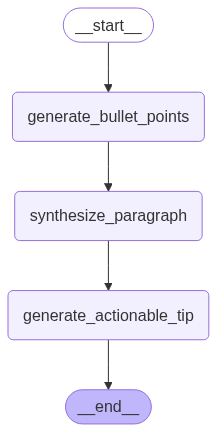

In [ ]:
app

In [ ]:
print("--- RUNNING AI DIGEST GENERATION AGENT ---")
inputs = {"raw_data": student_weekly_data}
result = app.invoke(inputs)

print("\n\n================================\n")
print("--- FINAL GENERATED DIGEST FOR PARENT DASHBOARD ---")
print(json.dumps(result['final_digest'], indent=2))

--- RUNNING AI DIGEST GENERATION AGENT ---
---NODE: Generating Bullet Points---
Generated Bullet Points:
- Completed **Module 3: Sine and Cosine Functions** and earned an **85 %** on the quiz.  
- Spent **4.5 hours** studying, submitting **2 assignments** and missing **1**.  
- Demonstrated solid effort overall, but **word‑problem skills** remain the weakest area.
---NODE: Synthesizing Paragraph---
Synthesized Paragraph: Alex has successfully completed Module 3 on Sine and Cosine Functions, earning a solid 85 % on the quiz—a clear sign of his growing understanding of trigonometric concepts. Over the past week he devoted 4.5 hours to studying, turned in two assignments on time, and missed only one, showing consistent effort and good time‑management skills. While his overall performance is commendable, we’ve noticed that word‑problem solving remains his weakest area; focusing a little extra practice on translating real‑world scenarios into mathematical equations will help him strengthen 